Original dataset found [here](https://www.kaggle.com/akulbahl/covid19-airline-flight-delays-and-cancellations)

In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_regression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [ ]:
# make the dataset available to colab
drive.mount('/content/drive')

path_to_dataset = '/content/drive/My Drive/CISC849/CISC849013/jantojun2020.csv'
# path_to_dataset = '/content/drive/My Drive/CISC849013/jantojun2020.csv'

Mounted at /content/drive


In [ ]:
# load dataset
dataset = pd.read_csv(path_to_dataset)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (36) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
dataset.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,MKT_UNIQUE_CARRIER,MKT_CARRIER_FL_NUM,TAIL_NUM,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,ORIGIN_STATE_NM,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DEST_STATE_NM,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,DEP_TIME_BLK,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,ARR_DELAY_GROUP,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,2020,1,1,1,3,1/1/2020,WN,5888,N951WN,ONT,"Ontario, CA",CA,California,SFO,"San Francisco, CA",CA,California,1810,1851.0,41.0,41.0,1.0,2.0,1800-1859,44.0,1935.0,2049.0,4.0,1945,2053.0,68.0,68.0,1.0,4.0,1900-1959,0,NaN,95.0,122.0,74.0,363,2,8.0,0.0,27.0,0.0,33.0
1,2020,1,1,1,3,1/1/2020,WN,6276,N467WN,ONT,"Ontario, CA",CA,California,SFO,"San Francisco, CA",CA,California,1150,1146.0,-4.0,0.0,0.0,-1.0,1100-1159,13.0,1159.0,1310.0,8.0,1320,1318.0,-2.0,0.0,0.0,-1.0,1300-1359,0,NaN,90.0,92.0,71.0,363,2,NaN,NaN,NaN,NaN,NaN
2,2020,1,1,1,3,1/1/2020,WN,4598,N7885A,ONT,"Ontario, CA",CA,California,SJC,"San Jose, CA",CA,California,2020,2016.0,-4.0,0.0,0.0,-1.0,2000-2059,8.0,2024.0,2121.0,3.0,2130,2124.0,-6.0,0.0,0.0,-1.0,2100-2159,0,NaN,70.0,68.0,57.0,333,2,NaN,NaN,NaN,NaN,NaN
3,2020,1,1,1,3,1/1/2020,WN,4761,N551WN,ONT,"Ontario, CA",CA,California,SJC,"San Jose, CA",CA,California,1340,1350.0,10.0,10.0,0.0,0.0,1300-1359,10.0,1400.0,1503.0,2.0,1455,1505.0,10.0,10.0,0.0,0.0,1400-1459,0,NaN,75.0,75.0,63.0,333,2,NaN,NaN,NaN,NaN,NaN
4,2020,1,1,1,3,1/1/2020,WN,5162,N968WN,ONT,"Ontario, CA",CA,California,SJC,"San Jose, CA",CA,California,915,916.0,1.0,1.0,0.0,0.0,0900-0959,6.0,922.0,1019.0,4.0,1035,1023.0,-12.0,0.0,0.0,-1.0,1000-1059,0,NaN,80.0,67.0,57.0,333,2,NaN,NaN,NaN,NaN,NaN


In [ ]:
dataset_not_cancelled = dataset[dataset['CANCELLED']==0]
print(dataset_not_cancelled.shape)
not_cancelled_flights = dataset_not_cancelled.shape[0]

(2462921, 47)


In [ ]:
dataset_cancelled = dataset[dataset['CANCELLED']==1]
print(dataset_cancelled.shape)
cancelled_flights = dataset_cancelled.shape[0]

(282926, 47)


In [ ]:
dataset_departure_delay = dataset_not_cancelled[dataset_not_cancelled['DEP_DELAY']>0]
print(dataset_departure_delay.shape)
delayed_departure_flights = dataset_departure_delay.shape[0]

(538369, 47)


In [ ]:
dataset_arrival_delay = dataset_not_cancelled[dataset_not_cancelled['ARR_DELAY']>0]
print(dataset_arrival_delay.shape)
delayed_arrival_flights = dataset_arrival_delay.shape[0]

(562150, 47)


In [ ]:
percentage_of_cancelled_flights = (cancelled_flights/(cancelled_flights + not_cancelled_flights)) * 100
print('Percentage of Cancelled Flights', str(percentage_of_cancelled_flights) + '%')

delayed_flights = 0

# get a subset of the dataset of the flights that were cancelled
delayed_dataset = dataset_not_cancelled[['DEP_DELAY', 'ARR_DELAY']]
delayed_dataset = delayed_dataset.to_numpy()

for i in range(len(delayed_dataset)):
  # get flights with a delayed departure and delayed arrival
  if delayed_dataset[i][0] > 0.0 and delayed_dataset[i][1] > 0.0:
    delayed_flights += 1
#   # get flights with a delayed departure and NO delayed arrival
  elif delayed_dataset[i][0] > 0.0 and delayed_dataset[i][1] <= 0.0:
    delayed_flights += 1
#   # get flights with NO delayed departure and a delayed arrival
  elif delayed_dataset[i][0] <= 0.0 and delayed_dataset[i][1] > 0.0:
    delayed_flights += 1



print('Delayed Flights:', delayed_flights)
print('Percentage of Flights Delayed', str((delayed_flights/not_cancelled_flights) * 100) + '%')

Percentage of Cancelled Flights 10.303778761161857%
Delayed Flights: 741691
Percentage of Flights Delayed 30.11428299973893%


Looking above, we see that there were 282,926 cancelled flights and 2,462,921 flights that were not cancelled. About 11.5% of all flights in the dataset were cancelled. For the flights not cancelled, 741,691 of them experienced either an arrival or departure delay. This equates to ~30% of not cancelled flights seeing some type of delay. However, for this project, we will only focus on cancelled flights

Looking at the data, we are missing some values. We will assume that any missing/null value in a column is treated as 0 after selecting which features to keep.

We are also going to drop columns that are not of any value just by looking at the dataset. The columns that will be dropped represent date and time stamps, the year (which is all 2020), redundant data, and columns that contain null values for flights that were cancelled. These columns are listed below and are subsequently dropped.

In [ ]:
dataset.drop(columns=['YEAR', 'CANCELLATION_CODE', 'WHEELS_OFF', 'WHEELS_ON', 'FL_DATE', 'TAXI_OUT', 'TAXI_IN', 'TAIL_NUM'], inplace=True)
dataset.drop(columns=['ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'ORIGIN_STATE_NM', 'DEST_CITY_NAME', 'DEST_STATE_ABR', 'DEST_STATE_NM'], inplace=True)
dataset.drop(columns=['CARRIER_DELAY', 'SECURITY_DELAY', 'NAS_DELAY', 'WEATHER_DELAY', 'LATE_AIRCRAFT_DELAY', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME'], inplace=True)
dataset.drop(columns=['DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP', 'ARR_TIME', 'ARR_DELAY', 'ARR_DELAY_NEW'], inplace=True)
dataset.drop(columns=['ARR_DEL15', 'ARR_DELAY_GROUP', 'MKT_CARRIER_FL_NUM'], inplace=True)
dataset = dataset.fillna(0.0)

We want to transform the remaining categorical features into numerical features so we can use them to predict which flights will be cancelled

In [ ]:
label_encoder = LabelEncoder()
dataset['MKT_UNIQUE_CARRIER'] = label_encoder.fit_transform(dataset['MKT_UNIQUE_CARRIER'])
dataset['ORIGIN'] = label_encoder.fit_transform(dataset['ORIGIN'])
dataset['DEST'] = label_encoder.fit_transform(dataset['DEST'])
dataset['DEP_TIME_BLK'] = label_encoder.fit_transform(dataset['DEP_TIME_BLK'])
dataset['ARR_TIME_BLK'] = label_encoder.fit_transform(dataset['ARR_TIME_BLK'])

In [ ]:
dataset.head()

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,MKT_UNIQUE_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME_BLK,CANCELLED,CRS_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP
0,1,1,1,3,9,255,322,1810,13,1945,14,0,95.0,363,2
1,1,1,1,3,9,255,322,1150,6,1320,8,0,90.0,363,2
2,1,1,1,3,9,255,329,2020,15,2130,16,0,70.0,333,2
3,1,1,1,3,9,255,329,1340,8,1455,9,0,75.0,333,2
4,1,1,1,3,9,255,329,915,4,1035,5,0,80.0,333,2


## Feature analysis for cancellation

With the 47 features we have:

'QUARTER' is kept. But maybe it can be dropped because we have 'MONTH'.

'MONTH' is kept.

'DAY_OF_MONTH' is kept.

'DAY_OF_WEEK' is kept.

'MKT_UNIQUE_CARRIER' has 10 values, we can convert it to the unique integer.

'ORIGIN' is kept. It is 3-Letter airport abbreviation.

'DEST' is kept. It is 3-Letter airport abbreviation.

'CRES_DEP_TIME' is kept. It is scheduled departure time.

'DEP_TIME_BLK' is kept. It is scheduled departure time in hourly block. But I'm thinking maybe this is kept while 'CRES_DEP_TIME' can be dropped?

'CRES_ARR_TIME' is kept. It is scheduled arrival time.

'ARR_TIME_BLK' is kept. It is scheduled arrival time in hourly block. But I'm thinking maybe this is kept while 'CRES_ARR_TIME' can be dropped?

'CANCELLED' is kept. It is the target.

'CRS_ELAPSED_TIME' is kept. It is scheduled total flight time.

'DISTANCE' is kept.

'DISTANCE_GROUP' is kept (not sure).

##Questions
After these drop, we have 15 featrues for training. It turns out that the cancellation are concentrated in March, April, and May. See belowing plots. Do you think predicting cancellation is a good task? Maybe predict delay?

Also, TPOT is ran in CPU? It is truly slow as we have a huge data size.


In [ ]:
# Find out the importance/significance of each feature using a Random Forest Classifier
train_set = dataset.drop(columns=['CANCELLED'])
features_list = list(train_set.select_dtypes(include=[np.number]).columns.values)

x_data = train_set[features_list].to_numpy()

y_data = dataset[['CANCELLED']]
y_data = y_data[['CANCELLED']].to_numpy()
y_data = y_data.reshape(y_data.shape[0], )

rf_clf = RandomForestClassifier()

rf_clf.fit(x_data, y_data)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
sorted_data_significance = np.argsort(rf_clf.feature_importances_)[::-1]
for index in sorted_data_significance:
    print(f"{features_list[index]}: {rf_clf.feature_importances_[index]}")

MONTH: 0.18997716886491045
DAY_OF_MONTH: 0.16921423658455906
CRS_ARR_TIME: 0.07864146747125826
DISTANCE: 0.0767601469345592
CRS_DEP_TIME: 0.0745505741286572
CRS_ELAPSED_TIME: 0.07017783909447121
DEST: 0.06537914541460725
ORIGIN: 0.06528599484371878
DAY_OF_WEEK: 0.06366701432682308
QUARTER: 0.03922415756427385
MKT_UNIQUE_CARRIER: 0.03882475720065258
DEP_TIME_BLK: 0.026994333354070827
ARR_TIME_BLK: 0.026310767262505086
DISTANCE_GROUP: 0.014992396954933054


In [ ]:
# Perform feature selection to verify the results of the Random Forest Classification
# train_set = dataset.drop(columns=['CANCELLED'])
# features_list = list(train_set.select_dtypes(include=[np.number]).columns.values)
# x_data = train_set[numeric_features_list].to_numpy()
# y_data = dataset[['CANCELLED']]
# y_data = y_data[['CANCELLED']].to_numpy()
# y_data = y_data.reshape(y_data.shape[0], )

feature_selector = SelectKBest(mutual_info_classif, k=5)
best_feature = feature_selector.fit_transform(x_data, y_data)
sorted_indices = np.argsort(feature_selector.scores_)[::-1]

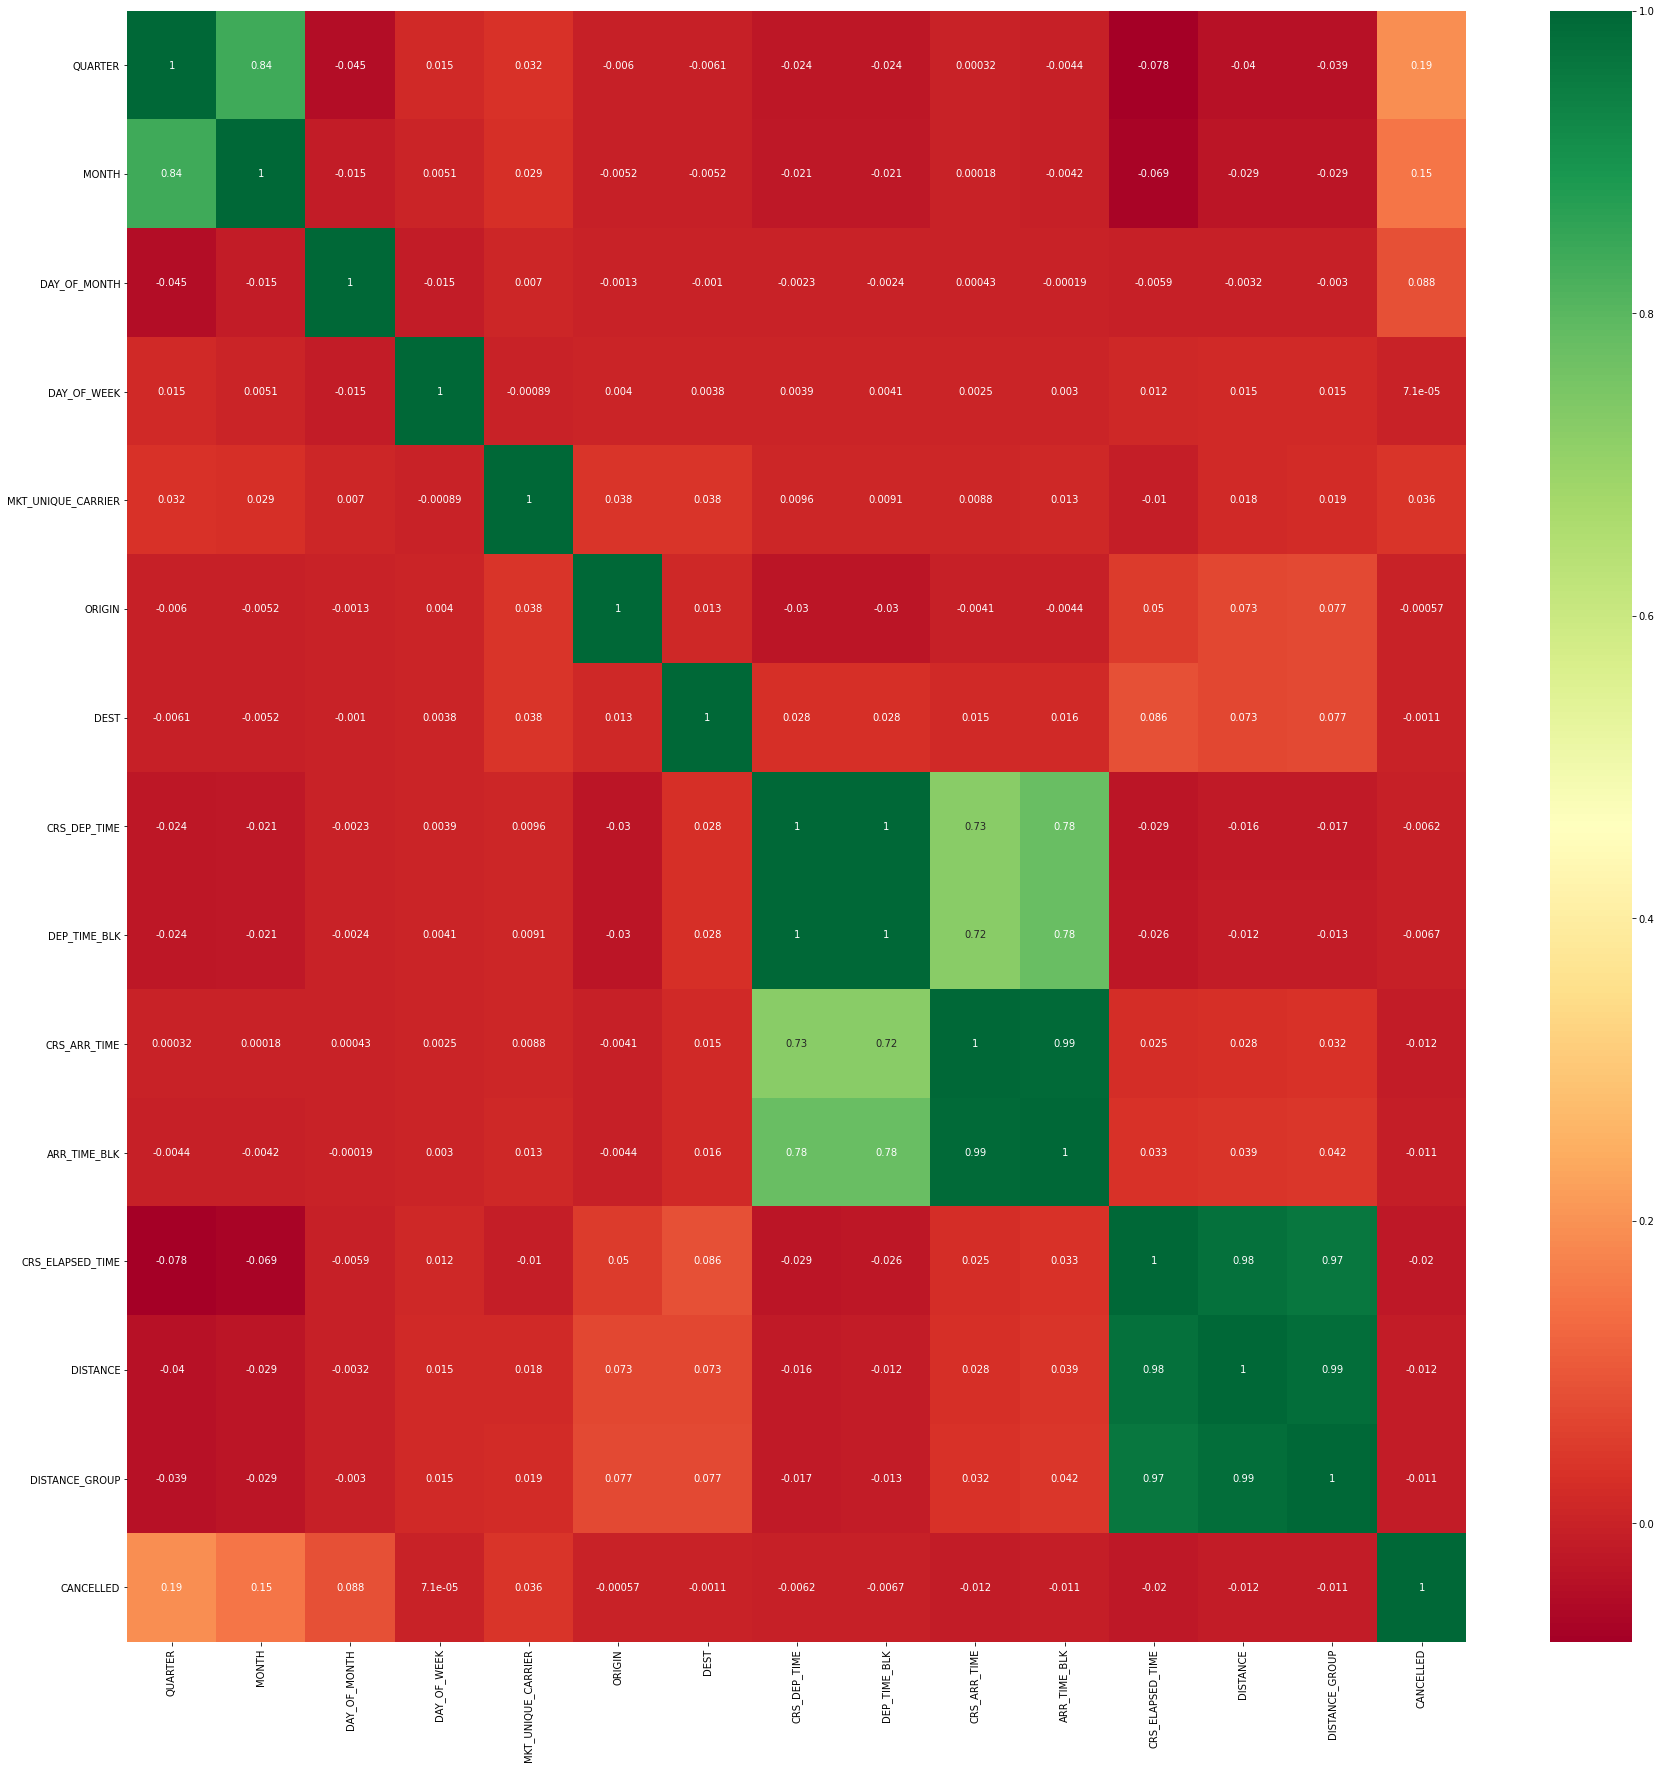

In [ ]:
# Create a correlation matrix of the features in the dataset to see how well they correlate with flights that were cancelled

data = dataset[features_list + ['CANCELLED']]
figure = plt.figure(figsize=(30, 30))
figure.set_facecolor('white')
sns.heatmap(data.corr(), annot=True, cmap="RdYlGn")

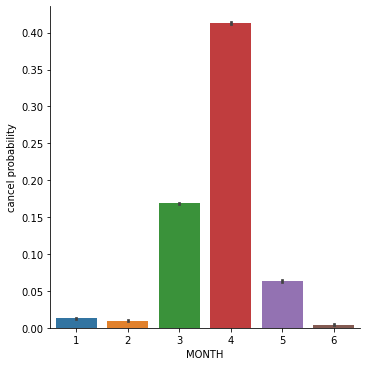

In [ ]:
plot = sns.catplot(x="MONTH", y="CANCELLED", kind="bar", data=dataset).set_ylabels("cancel probability")

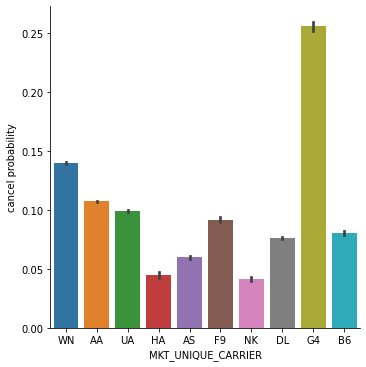

In [ ]:
plot = sns.catplot(x="MKT_UNIQUE_CARRIER", y="CANCELLED", kind="bar", data=dataset).set_ylabels("cancel probability")

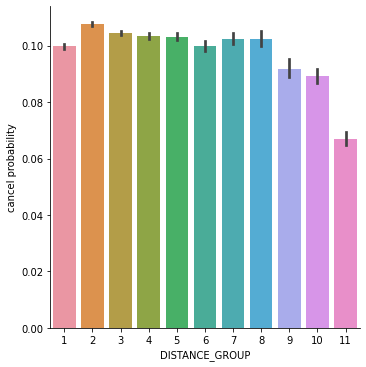

In [ ]:
plot = sns.catplot(x="DISTANCE_GROUP", y="CANCELLED", kind="bar", data=dataset).set_ylabels("cancel probability")

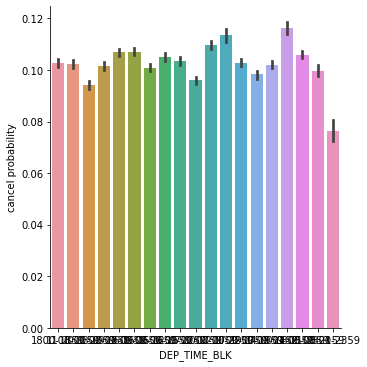

In [ ]:
plot = sns.catplot(x="DEP_TIME_BLK", y="CANCELLED", kind="bar", data=dataset).set_ylabels("cancel probability")

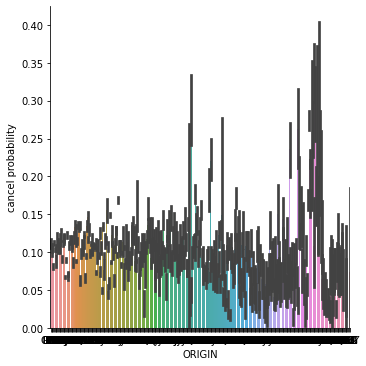

In [ ]:
plot = sns.catplot(x="ORIGIN", y="CANCELLED", kind="bar", data=dataset).set_ylabels("cancel probability")

In [ ]:
# if the RandomForest Classifier above is not run, uncomment the below lines
# train_set = dataset.drop(columns=['CANCELLED'])
# numeric_features_list = list(train_set.select_dtypes(include=[np.number]).columns.values)

# x_data = train_set[numeric_features_list].to_numpy()

# y_data = dataset[['CANCELLED']]
# y_data = y_data[['CANCELLED']].to_numpy()
# y_data = y_data.reshape(y_data.shape[0], )

# create a Random Forest Classifier
random_forest_clf = RandomForestClassifier()

# perform 5-fold cross-validation
scores = cross_val_score(random_forest_clf, x_data, y_data, cv=5)

# find the accuracy of the folds by getting the average of them
accuracy = scores.mean()
print(accuracy)

0.7624877659089565


In [ ]:
features = dataset.drop(columns=['CANCELLED'])

train_set, test_set, train_labels, test_labels = train_test_split(features, dataset['CANCELLED'])

In [ ]:
rf_clf = RandomForestClassifier()
rf_clf.fit(train_set, train_labels)
rf_predictions = rf_clf.predict(test_set)

rf_accuracy = accuracy_score(test_labels, rf_predictions)
print('Random Forest Classifier Accuracy (no cross validation):', rf_accuracy)

Random Forest Classifier Accuracy (no cross validation): 0.9327537431059549


In [ ]:
# use a Naïve Bayes Classifier to see if it predicts cancelled flights better than the RandomForest Classifier
nb_clf = GaussianNB()
nb_clf.fit(train_set, train_labels)
nb_predictions = nb_clf.predict(test_set)

# get the accuracy of the Naïve Bayes Classifier on the Data to find out how
# well NB predicts cancelled flights
nb_accuracy = accuracy_score(test_labels, nb_predictions)
print('Naïve Bayes Classifier Accuracy:', nb_accuracy)

Naïve Bayes Classifier Accuracy: 0.8936066380950438


In [ ]:
# use a Decision Tree Classifier to see how it compares to the NB Classifier and
# the RF Classifier
dt_clf = DecisionTreeClassifier()
dt_clf.fit(train_set, train_labels)
dt_predictions = dt_clf.predict(test_set)
dt_accuracy = accuracy_score(test_labels, dt_predictions)
print('Decision Tree Classifier Accuracy:', dt_accuracy)

Decision Tree Classifier Accuracy: 0.9166465150292369


In [ ]:
# use a KNN Classifier to see how it compares to the other classifiers
# we use the default of 5 nearest neighbors
knn_clf = KNeighborsClassifier()
knn_clf.fit(train_set, train_labels)
knn_predictions = knn_clf.predict(test_set)
knn_accuracy = accuracy_score(test_labels, knn_predictions)
print('K Nearest Neighbors Classifier Accuracy:', knn_accuracy)

K Nearest Neighbors Classifier Accuracy: 0.909507008399591
